### Customized your own nodes in gQuant

In previous blog, we showed how to use gQuant to accelerate quantitive finance workflows in the GPU easily. The accleration in GPU is turned on by using GPU cuDF dataframe in the computation graph. cuDF is an on going project that a few dataframe methods haven't been implemented yet. Sometimes the quantitative work needs some special logics to manipulate the data that no direct support at cuDF dataframe is available yet. One solution is to build customized GPU kernels to implement them.

This blog will show how to use different methods to implement customized GPU kernels in Python

### Enviroment setup

Load following necessary Python modules

In [2]:
import sys
sys.path.append('..')
from gquant.dataframe_flow import run, load_workflow, viz_graph, get_graph, Node
import nxpd
import cudf
import numpy as np
from nxpd import draw
from numba import cuda
import cupy
import math
import dask
import dask_cudf

Define a utility function to verify the results:

In [3]:
def verify(ground_truth, computed):
    max_difference = cudf.sqrt((ground_truth - computed)**2).max()
    assert(max_difference < 1e-8)
    return max_difference

### A toy Problem, compute the distance of points to the origin
The toy problem is to compute the distance of the list of points in 2-D space to the origin. 

We create a source Node in the graph that generate a cuDF dataframe containing 1000 random points.

In [4]:
class PointNode(Node):

    def columns_setup(self,):
        self.required = {}
        self.addition = {"x": "float64",
                         "y": "float64"}

    def process(self, inputs):
        df = cudf.DataFrame()
        df['x'] = np.random.rand(1000)
        df['y'] = np.random.rand(1000)
        return df

The distance can be computed via cuDF methods. Following is to create a DistanceNode that is used to add a distance column to the output dataframe. We use it as a ground truth to verify results later

In [5]:
class DistanceNode(Node):

    def columns_setup(self,):
        self.required = {"x": "float64",
                         "y": "float64"}
        self.addition = {"distance": "float64"}

    def process(self, inputs):
        df = inputs[0]
        df['distance'] = (df['x']**2 + df['y']**2).sqrt()
        return df

Having these two nodes, we can construct a simple graph to compute the distance.

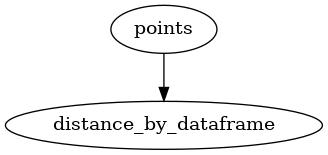

In [6]:
input_node = {"id": "points",
              "type": PointNode,
              "conf": {},
              "inputs": []}
distance_node = {"id": "distance_by_dataframe",
                 "type": DistanceNode,
                 "conf": {},
                 "inputs": ["points"]}
G = viz_graph([input_node, distance_node])
draw(G, show='ipynb')

Evaluate the output node in the graph, we get the distances:

In [7]:
o = run([input_node, distance_node], outputs=['distance_by_dataframe'], replace={})
print(o[0])

                     x                    y             distance
0  0.24744864211461703   0.8420559661943564   0.8776611422911914
1   0.1543558871885372   0.4424360528069907  0.46858873304123594
2   0.3635119940625038   0.3568795742429829   0.5094153514953692
3   0.7150110593476766   0.4128603315583932   0.8256479082296478
4   0.3209373463254228   0.4751279408906893   0.5733649278438914
5   0.7138497382915616   0.6844185528130492   0.9889439844064171
6   0.8851171935524784  0.13169773091112058   0.8948612957600488
7   0.4820764687348812  0.36869068683647144   0.6069024174180244
8   0.4802436552114432    0.618830235076933   0.7833165568377958
9   0.4720569876068379  0.10552922248129881   0.4837088135913483
[990 more rows]


### Customized Kernel by Numba library

Numba is an excellent python library that accelerates the numerical computations. Most importantly, Numba supports CUDA GPU programming by directly compiling a restricted subset of Python code into CUDA kernels and device functions following the CUDA execution model.
cuDF series can be converted to GPU arrays that the Numba library recognizes.

The Numba GPU kernel is written in Python and translated into GPU code in the runtime. We just need to decorate the Python function with `@cuda.jit`.

In [8]:
@cuda.jit
def distance_kernel(x, y, distance, array_len):
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    if i < array_len:
        distance[i] = math.sqrt(x[i]**2 + y[i]**2)

Define a Node that calls this Numba kernel to compute the distance and save the result into `distance_numba` column

In [9]:
class NumbaDistanceNode(Node):

    def columns_setup(self,):
        self.required = {"x": "float64",
                         "y": "float64"}
        self.addition = {"distance_numba": "float64"}
        self.delayed_process = True

    def process(self, inputs):
        df = inputs[0]
        number_of_threads = 16
        number_of_blocks = (len(df) - 1)//number_of_threads + 1
        df['distance_numba'] = 0.0
        distance_kernel[(number_of_blocks,), (number_of_threads,)](df['x'].data.to_gpu_array(), df['y'].data.to_gpu_array(), df['distance_numba'].data.to_gpu_array(), len(df))
        return df

Node, we added `self.delayed_process = True` flag in the `columns_setup`. This is necesary if we want to include this node into the Dask computation graph. Normally, the `dask_cuDF` dataframe doesn't support GPU customized kernels. We can use `to_delayed` and `from_delayed` low level interface to work around it. If the flag is added, the gQuant handles this automatically under the hood.


### Customized Kernel by CuPy library

Numba is to compile the Python code into GPU code in the runtime. It has some limitations to use it. And it adds some overhead using it too. 
When the Python process calls the Numba kernel for the first time, it take some CPU time to compile the Python code. If advanced features are needed and lattency is important, CuPy can be used to compile raw C/C++ CUDA code.

`CuPy` GPU kernel is esentially a C/C++ GPU kernel, here is one example:

In [10]:
raw_kernel = cupy.RawKernel(r'''
    extern "C" __global__
    void compute_distance(const double* x, const double* y, double* distance, int arr_len) {
        int tid = blockDim.x * blockIdx.x + threadIdx.x;
        if (tid < arr_len){
        distance[tid] = sqrt(x[tid]*x[tid] + y[tid]*y[tid]);
        }
    }
''', 'compute_distance')

Define a Node that calls this CuPy kernel to compute the distance and save the results into `distance_cupy` column

In [11]:
class CupyDistanceNode(Node):

    def columns_setup(self,):
        self.required = {"x": "float64",
                         "y": "float64"}
        self.addition = {"distance_cupy": "float64"}
        self.delayed_process = True

    def process(self, inputs):
        df = inputs[0]
        cupy_x = cupy.asarray(df['x'].data.to_gpu_array())
        cupy_y = cupy.asarray(df['y'].data.to_gpu_array())
        number_of_threads = 16
        number_of_blocks = (len(df) - 1)//number_of_threads + 1
        dis = cupy.arange(len(df), dtype=cupy.float64)
        raw_kernel((number_of_blocks,), (number_of_threads,), (cupy_x, cupy_y, dis, len(df)))
        df['distance_cupy'] = dis
        return df

Node, `self.delayed_process = True` flag is added for the same reason.

### Compute the Nodes with customized GPU kernels

First we construct the computation graph for gQuant

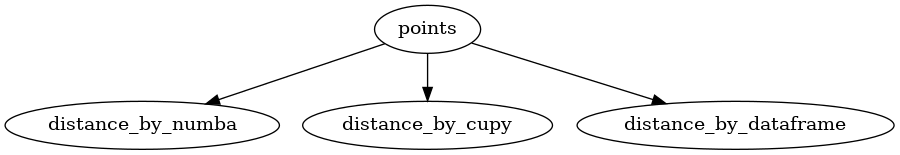

In [12]:
numba_distance_node = {"id": "distance_by_numba",
                       "type": NumbaDistanceNode,
                       "conf": {},
                       "inputs": ["points"]}
cupy_distance_node = {"id": "distance_by_cupy",
                      "type": CupyDistanceNode,
                      "conf": {},
                      "inputs": ["points"]}

graph = [input_node, numba_distance_node, cupy_distance_node, distance_node]
G = viz_graph(graph)
draw(G, show='ipynb')

In [13]:
numba_df, cupy_df, gt_df = run(graph,
                               outputs=['distance_by_numba', 'distance_by_cupy',
                                        'distance_by_dataframe'],
                               replace={})

Use `verify` method defined above to verify the results:

In [14]:
print(verify(numba_df['distance_numba'], gt_df['distance']))
print(verify(cupy_df['distance_cupy'], gt_df['distance']))

2.220446049250313e-16
2.220446049250313e-16


### Dask distributed computation

To evaluate the Nodes with customized GPU kernels in the GPU in Dask environment is straightfowrd as we already added `self.delayed_process = True` flag.

We first start the Dask environment

In [15]:
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

/conda/envs/rapids/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:40522 Dashboard: http://127.0.0.1:43946/status,Cluster Workers: 8 Cores: 8 Memory: 536.39 GB


The Dask status page can be popped up in the brwoser by following javascript commands:

In [16]:
from IPython.display import HTML
javascript = """
<script type="text/Javascript">
    function check_status(){
        var url = document.location.href;
        var index = url.indexOf(':8888');
        var status = url.substr(0, index)+":8787";
        window.open(status,'_blank');
    }
    check_status();
</script>
"""
HTML(javascript)

We need a Node that partition the `cudf` dataframe into `dask_cudf` dataframe. Here we make 8 partitions:

In [17]:
class DistributedNode(Node):

    def columns_setup(self,):
        self.required = {"x": "float64",
                         "y": "float64"}

    def process(self, inputs):
        df = inputs[0]
        return dask_cudf.from_cudf(df, npartitions=8)

The computation graph need to be changed to include this node

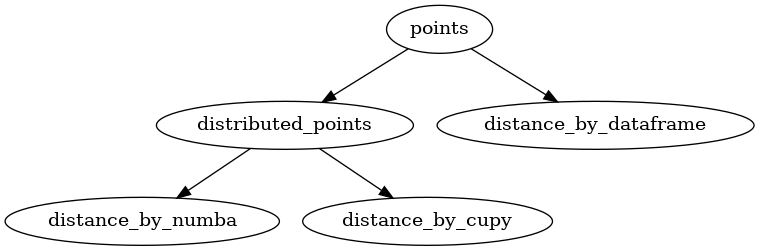

In [18]:
input_node = {"id": "points",
              "type": PointNode,
              "conf": {},
              "inputs": []}
distributed_node = {"id": "distributed_points",
                    "type": DistributedNode,
                    "conf": {},
                    "inputs": ["points"]}
distance_node = {"id": "distance_by_dataframe",
                 "type": DistanceNode,
                 "conf": {},
                 "inputs": ["points"]}
numba_distance_node = {"id": "distance_by_numba",
                       "type": NumbaDistanceNode,
                       "conf": {},
                       "inputs": ["distributed_points"]}
cupy_distance_node = {"id": "distance_by_cupy",
                      "type": CupyDistanceNode,
                      "conf": {},
                      "inputs": ["distributed_points"]}
graph = [input_node, distributed_node, distance_node, numba_distance_node, cupy_distance_node]
G = viz_graph(graph)
draw(G, show='ipynb')

In [19]:
numba_df, cupy_df, gt_df = run(graph, ['distance_by_numba', 'distance_by_cupy', 'distance_by_dataframe'], {})

Verify the results:

In [20]:
print(verify(numba_df['distance_numba'].compute(), gt_df['distance']))
print(verify(cupy_df['distance_cupy'].compute(), gt_df['distance']))

2.220446049250313e-16
2.220446049250313e-16


There is one limitation for using customized kernels in the Nodes in the Dask environment. Each GPU kernel is assumed to work on one partition of the dataframe. So if the computation depends on other partitions of the dataframe, this approach doesn't work.

### Conclusions

Using customized GPU kernels allows data scientists to implement lots of complicated logics. We show it can be done either by Numba method or CuPy method.

The Numba method allows data scientists to use their familar Python langague to write GPU kernels. It is easy to write and relatively fast in performance. However there is some overheads of compiling the kernels whenever this GPU kernel is used for the first time in the Python process. Currently Numba library only supports primitive data types. Some advance CUDA programming features like function pointer and function recursions are not supported. 

The Cupy method is very flexible because data scientists is writing C++/C GPU kernels. All the CUDA programming features are supported. It compiles the kernel and caches to the filesystem. The launch overhead is low. As GPU kernel is built statically, the runtime efficiency is highest. However it is hard for data scientists to use becasue C/C++ programming skills are needed. 

There is a comparison table

| Methods | Development Difficulty | Flexibility | Efficiency | Lattency |
|---|---|---|---|---|
| Numba method | medium | medium | low | high |
| CuPy method | hard | high  | high | low |

We recommend data scientists to choose the right approach to balance the efficiency, lattency, difficulty and flexibility for their workflow. 

In this blog, we also show wrapping the customize GPU kernels in gQuant nodes, it is easy to include them into the Dask distributed computation graph. Because the gQuant handles the low-level Daks interface for the developer.